# Assignment — Node Embeddings

In [1]:
! pip install -U gensim==3.6.0

     |████████████████████████████████| 23.2MB 1.4MB/s 
  Created wheel for gensim: filename=gensim-3.6.0-cp37-cp37m-linux_x86_64.whl size=24214535 sha256=87f140b7c96dd5602698a30aaa028ca26de4e9be0b0e3a431bdcde8b44b6a897
  Stored in directory: /root/.cache/pip/wheels/97/37/bd/2b80cbc3be93cdf9dd3348dc8b5e659e059f5b51fcecc706be
Successfully built gensim
ERROR: karateclub 1.0.24 has requirement gensim==3.8.3, but you'll have gensim 3.6.0 which is incompatible.
  Found existing installation: gensim 3.8.3
    Uninstalling gensim-3.8.3:
      Successfully uninstalled gensim-3.8.3


In [2]:
import networkx as nx
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import requests
from time import time
import matplotlib.pyplot as plt

### CORA Exploratory Data Analysis

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Let us take a closer look at this dataset.

In [3]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/cora_cites.txt'
open('cora_cites.txt', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/cora_content.txt'
open('cora_content.txt', 'wb').write(requests.get(url).content);

Number of nodes in the graph

In [4]:
cora = nx.read_edgelist('cora_cites.txt')
len(cora)

2708

Number of nodes in a gigantic connected component (GCC)

In [5]:
gcc_nodes = sorted(list(nx.connected_components(cora)), 
                   key=lambda x: len(x))[-1]
gcc_cora = cora.subgraph(gcc_nodes).copy()
len(gcc_cora)

2485

Nodes content

In [6]:
cora_content = pd.read_csv('cora_content.txt', sep='	', 
                           header=None, index_col=0)
cora_content.index = cora_content.index.astype('str')
cora_content.index.name = 'node'
cora_content.iloc[:5, :20]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
node,,,,,,,,,,,,,,,,,,,,
31336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1061127,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1106406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. In this assignment, we will only work with categories and will not touch any information about words.

Examples of node categories

In [7]:
category = cora_content.loc[gcc_nodes, [1434]]
category = category.rename(columns={1434: 'category_name'})
category.head()

,category_name
node,
237489,Neural_Networks
395725,Neural_Networks
642641,Probabilistic_Methods
134314,Probabilistic_Methods
13269,Probabilistic_Methods


Category distribution

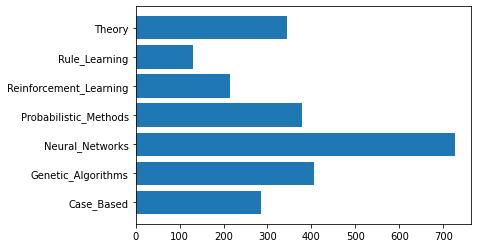

In [8]:
plt.barh(*np.unique(category, return_counts=True));

Rename categories to integer numbers (ids)

In [9]:
category['category_id'] = np.unique(category.category_name, 
                                    return_inverse = True)[1]
category.head()

,category_name,category_id
node,,
237489,Neural_Networks,2
395725,Neural_Networks,2
642641,Probabilistic_Methods,3
134314,Probabilistic_Methods,3
13269,Probabilistic_Methods,3


Assortativity coefficient

In [10]:
nx.set_node_attributes(gcc_cora, category.category_id.to_dict(), 'category')
gcc_cora = nx.convert_node_labels_to_integers(gcc_cora)
round(nx.attribute_assortativity_coefficient(gcc_cora, 'category'), 2)

0.76

### Task 1. Node embedding visualization (1.5 points)

Let us compare embedding algorithms that we saw in previous assignments: 
* Laplacian Eigenmaps
* Truncated SVD of an adjacency matrix
* DeepWalk
* Walklets

There is a usefull python package [*Karate Club*](https://github.com/benedekrozemberczki/karateclub) that contains implementations of these algorithms. Also we will use sklearn implementation of truncated SVD.

In [11]:
! pip install karateclub==1.0.24 -q

In [12]:
from karateclub import DeepWalk, Walklets, LaplacianEigenmaps
from sklearn.decomposition import TruncatedSVD, PCA

Embedding algorithms in Karate Club have a general interface

```
model.fit(graph)
embedding = model.get_embedding()
```

However, the one inconvenient thing is that Walklets make a concatenation of Word2Vec embeddings to obtain final embeddings. In this way, the output dimensionality will be Word2Vec dimensionality multiplied by window size. A piece of source code:

```python
def get_embedding(self) -> np.array:
    r"""Getting the node embedding.

    Return types:
        * **embedding** *(Numpy array)* - The embedding of nodes.
    """
    return np.concatenate(self._embedding, axis=1)
```

Sometimes, it is usefull to have deep representation of nodes, but  we want to compare embeddings with the same dimensionality, so let us define our own class `PCAWalklets` that inherits `Walklets` and performs PCA reduction of embeddings into `self.dimensions` in the `get_embedding` method.

In [13]:
class PCAWalklets(Walklets):
    def get_embedding(self):
        # YOUR CODE HERE
        embed = np.concatenate(self._embedding, axis=1)
        model = PCA(n_components=self.dimensions)
        model.fit(embed)
        return model.transform(embed)

In [14]:
test_model = PCAWalklets()
test_model.fit(nx.karate_club_graph())
test_emb = test_model.get_embedding()
assert test_emb.shape == (34, 32)

Now let us visualize the 2d embeddings.

Write a function `xy_embeddings` that takes a graph, compute 16d embeddings, reduce them into 2d via PCA and returns in the order:
* Laplacian Eigenmaps
* Truncated SVD of an adjacency matrix
* DeepWalk
* Walklets

*Hints:*
* *Suggested hyperparameters for DeepWalk and Walklets are `walk_number=10`, `walk_length=30`, `window_size=10`*
* *You do not need reduce Walklets embeddgins to 2d, just directly use `PCAWalklets` with dimensionality 2*

In [15]:
def xy_embeddings(graph):
    # YOUR CODE HERE
    deepwalk = DeepWalk(walk_number=10, walk_length=30, window_size=10,
                        dimensions=16)
    deepwalk.fit(graph)
    deep_walk_emb = deepwalk.get_embedding()
    PCA_model = PCA(n_components=2)
    PCA_model.fit(deep_walk_emb)
    deep_walk_emb = PCA_model.transform(deep_walk_emb)

    laplacian_eigenmaps = LaplacianEigenmaps(dimensions=16)
    laplacian_eigenmaps.fit(graph)
    laplacian_eigenmaps_emb = laplacian_eigenmaps.get_embedding()
    PCA_model.fit(laplacian_eigenmaps_emb)
    laplacian_eigenmaps_emb = PCA_model.transform(laplacian_eigenmaps_emb)

    pca_walklets = PCAWalklets(walk_number=10, walk_length=30, window_size=10,
                               dimensions=2)
    pca_walklets.fit(graph)
    pca_walklets_emb = pca_walklets.get_embedding()

    A = nx.to_numpy_array(graph)
    truncated_svd = TruncatedSVD(n_components=16)
    svd_emb = truncated_svd.fit_transform(A)
    PCA_model.fit(svd_emb)
    svd_emb = PCA_model.transform(svd_emb)

    return laplacian_eigenmaps_emb, svd_emb, deep_walk_emb, pca_walklets_emb

In [16]:
laplacian_emb, svd_emb, deep_walk_emb, walklets_emb = xy_embeddings(gcc_cora)
assert (deep_walk_emb.shape == laplacian_emb.shape 
        == svd_emb.shape == walklets_emb.shape == (2485, 2))
assert -0.5 < laplacian_emb.min() < laplacian_emb.max() < 0.5
assert svd_emb[0].sum() > 15
assert round(abs(np.corrcoef(deep_walk_emb[:, 0], deep_walk_emb[:, 1])[0][1]), 
             2) == 0
assert round(abs(np.corrcoef(walklets_emb[:, 0], walklets_emb[:, 1])[0][1]), 
             2) == 0

Next, here we get a list of category ids to color data points

In [17]:
category_id = nx.get_node_attributes(gcc_cora, 'category')
category_id = list(category_id.values())
category_id[:10]

[1, 1, 2, 1, 1, 1, 1, 1, 1, 1]

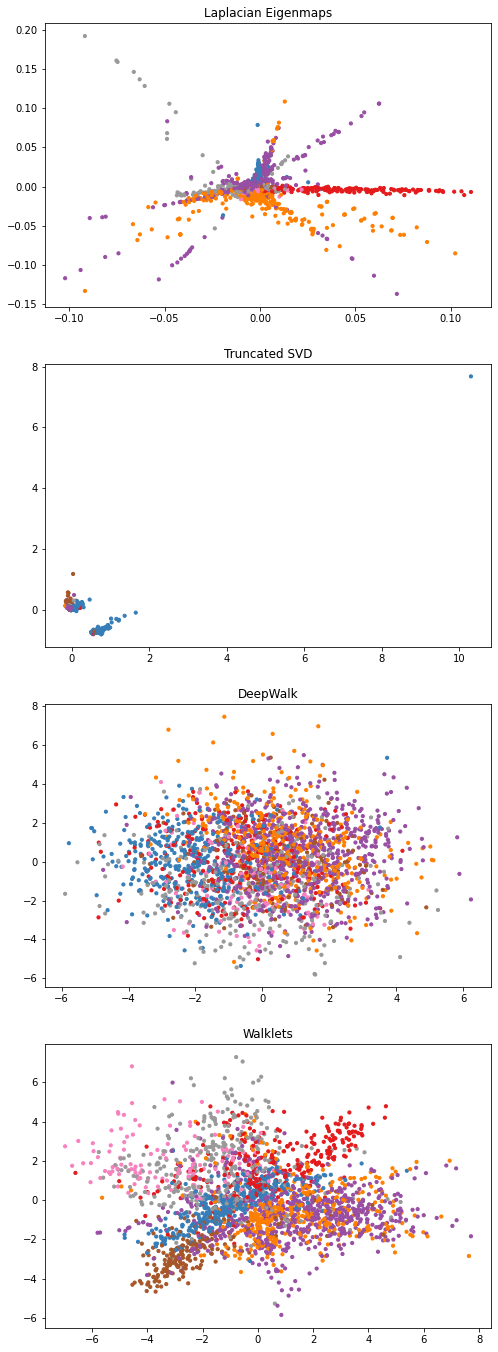

In [18]:
plt.figure(figsize=(8, 6*4))
cases = [[laplacian_emb, 'Laplacian Eigenmaps'], 
         [svd_emb, 'Truncated SVD'], 
         [deep_walk_emb, 'DeepWalk'], 
         [walklets_emb, 'Walklets']]
for i, (emb, title) in enumerate(cases):
    plt.subplot(4, 1, i+1)
    plt.scatter(emb[:, 0], emb[:, 1], c=category_id, cmap=plt.cm.Set1, s=10)
    plt.title(title)

### Task 2. Test set size dependency (1.5 points)

Let us compare the quality of embedding algorithms on classification tasks depending on the size of test set.

Write a function `embeddings_score` that takes a graph and computes 16d embeddigns, splits the dataset (X is embedding, y is category id) into train and test sets, fit `GradientBoostingClassifier` and returns a list of lists:
* Micro-F1 score of Laplacian Eigenmaps for the test size 0.99, 0.95, 0.9, 0.8, 0.7
* The same for Truncated SVD
* The same for Deepwalk
* The same for Walklets

*Hints:* 
* *Use `train_test_split` splitting method from sklearn*
* *Use `f1_score(y_test, y_pred, average='micro')` method from sklearn to calculate Micro-F1 score*
* *It is ok if it takes about 2 minutes in Colab*

In [19]:
def embeddings_score(graph):
    # YOUR CODE HERE
    deepwalk = DeepWalk(walk_number=10, walk_length=30, window_size=10,
                        dimensions=16)
    deepwalk.fit(graph)
    deep_walk_emb = deepwalk.get_embedding()


    laplacian_eigenmaps = LaplacianEigenmaps(dimensions=16)
    laplacian_eigenmaps.fit(graph)
    laplacian_eigenmaps_emb = laplacian_eigenmaps.get_embedding()

    pca_walklets = PCAWalklets(walk_number=10, walk_length=30, window_size=10,
                               dimensions=16)
    pca_walklets.fit(graph)
    pca_walklets_emb = pca_walklets.get_embedding()

    A = nx.to_numpy_array(graph)
    truncated_svd = TruncatedSVD(n_components=16)
    svd_emb = truncated_svd.fit_transform(A)

    labels = nx.get_node_attributes(graph, 'category')

    l = []

    for emb in [laplacian_eigenmaps_emb, svd_emb, deep_walk_emb, 
                pca_walklets_emb]:
      tmp = []
      for k in [0.99, 0.95, 0.9, 0.8, 0.7]:
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(emb, labels, test_size=k)
        model = GradientBoostingClassifier()
        model.fit(Xtrain, Ytrain)
        res = model.predict(Xtest)
        tmp.append(f1_score(Ytest, res, average='micro'))
      l.append(tmp)
    
    return l

In [20]:
scores = embeddings_score(gcc_cora)
scores = np.array(scores)
assert scores.shape == (4, 5)
assert scores.mean() > 0.5
X = np.stack([np.ones(5), np.arange(5)], axis=1)
y = scores.mean(axis=0)
assert (np.linalg.inv(X.T @ X) @ X.T @ y)[0] > 0.4
mean_res = scores.mean(axis=1)
assert mean_res[0] > mean_res[3] > mean_res[1] > mean_res[2]

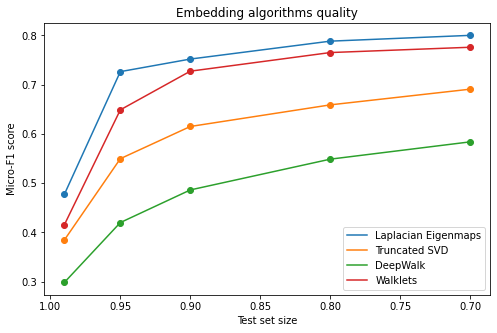

In [21]:
plt.figure(figsize=(8, 5))
labels = ['Laplacian Eigenmaps', 'Truncated SVD', 'DeepWalk', 'Walklets']
for i, score in enumerate(scores):
    plt.plot([0.99, 0.95, 0.9, 0.8, 0.7], score, label=labels[i])
    plt.scatter([0.99, 0.95, 0.9, 0.8, 0.7], score)
plt.legend()
plt.title('Embedding algorithms quality')
plt.xlabel('Test set size')
plt.ylabel('Micro-F1 score')
plt.gca().invert_xaxis()
plt.show()

### Task 3. Embedding dimensionality importance (2 points)

Another important property of the embedding is an ability to represent nodes in low-dimensional space. It will be great to quickly compress the most important and drop all excess imformation. Let us check how the dimensionality affects to quality and time cost.

Write a function `embeddings_dim` that takes a graph, computes embeddings, splits dataset into train and test sets with test size 0.95, computes Micro-F1 scores, time costs and returns a tuple:
* list of lists:
  * Micro-F1 score for 8d Laplacian Eigenmaps, Truncated SVD, DeepWalk, Walklets
  * The same for 16d
  * The same for 32d
  * The same for 64d
  * The same for 128d
* list of lists:
  * Time cost (seconds) for 8d Laplacian Eigenmaps, Truncated SVD, DeepWalk, Walklets
  * The same for 16d
  * The same for 32d
  * The same for 64d
  * The same for 128d

*Hints:*
* *Use `time()` to get a current time moment*
* *It is ok if it takes about 4 minutes in Colab*

In [22]:
import time


def embeddings_dim(graph):
    # YOUR CODE HERE
    l_scores = []
    l_times = []

    for d in [8, 16, 32, 64, 128]:
      labels = nx.get_node_attributes(graph, 'category')

      times = []
      scores = []


      for emb_name in ['laplacian', 'svd', 'deep_walk', 
                  'walklets_emb']:

          start_time = time.time()
          if emb_name == 'laplacian':
            laplacian_eigenmaps = LaplacianEigenmaps(dimensions=d)
            laplacian_eigenmaps.fit(graph)
            emb = laplacian_eigenmaps.get_embedding()
          if emb_name == 'svd':
            A = nx.to_numpy_array(graph)
            truncated_svd = TruncatedSVD(n_components=d)
            emb = truncated_svd.fit_transform(A)
          if emb_name == 'deep_walk':
            deepwalk = DeepWalk(walk_number=10, walk_length=30, window_size=10,
                                dimensions=d)
            deepwalk.fit(graph)
            emb = deepwalk.get_embedding()
          if emb_name == 'walklets_emb':
            pca_walklets = PCAWalklets(walk_number=10, walk_length=30, window_size=10,
                                dimensions=d)
            pca_walklets.fit(graph)
            emb = pca_walklets.get_embedding()
          Xtrain, Xtest, Ytrain, Ytest = train_test_split(emb, labels, test_size=0.95)
          model = GradientBoostingClassifier()
          model.fit(Xtrain, Ytrain)
          res = model.predict(Xtest)
          times.append(time.time() - start_time)
          scores.append(f1_score(Ytest, res, average='micro'))
      
      l_scores.append(np.array(scores))
      l_times.append(np.array(times))

    return np.array(l_scores), np.array(l_times)

In [23]:
scores, time_cost = embeddings_dim(gcc_cora)
scores, time_cost = np.array(scores), np.array(time_cost)
assert scores.shape == time_cost.shape == (5, 4)
smean = scores.mean(axis=0)
assert smean.argmin() == 2
assert smean[1] < smean[0]
assert smean[1] < smean[3]
assert smean.mean() > 0.5
tcmean = time_cost.mean(axis=0)
assert tcmean.argmin() in [0, 1]
assert tcmean.argmax() == 3
assert time_cost[0, 0] < time_cost[-1, 0]

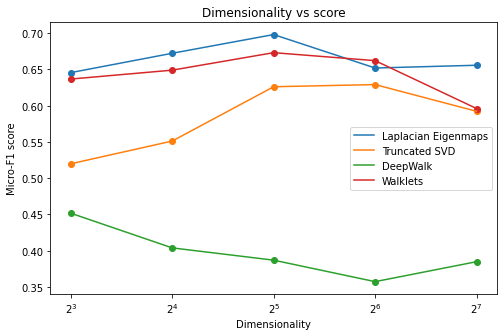

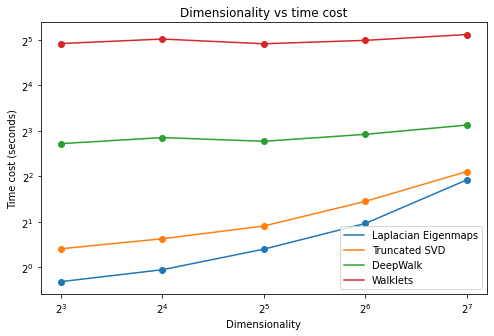

In [24]:
plt.figure(figsize=(8, 5))
labels = ['Laplacian Eigenmaps', 'Truncated SVD', 'DeepWalk', 'Walklets']
for i, score in enumerate(scores.T):
    plt.plot([8, 16, 32, 64, 128], score, label=labels[i])
    plt.scatter([8, 16, 32, 64, 128], score)
plt.legend()
plt.xscale('log', basex=2)
plt.xlabel('Dimensionality')
plt.ylabel('Micro-F1 score')
plt.title('Dimensionality vs score')
plt.show()

plt.figure(figsize=(8, 5))
for i, cost in enumerate(time_cost.T):
    plt.plot([8, 16, 32, 64, 128], cost, label=labels[i])
    plt.scatter([8, 16, 32, 64, 128], cost)
plt.legend()
plt.xscale('log', basex=2)
plt.yscale('log', basey=2)
plt.xlabel('Dimensionality')
plt.ylabel('Time cost (seconds)')
plt.title('Dimensionality vs time cost')
plt.show()

### Task 4. Node2Vec (3 points)

In the current task we will define node2vec embedding.
It is similar to the DeepWalk, but used biased random walks. It balance between breadth-  and depth-first searches to account for high order proximities.

`biased_random_walk` takes graph, node for which we sample random walk, length of walk, weight p with which we will move towards previous node and weight q with which we will move away from previous node.

Biased walk works with following algorithm:
1. Start random walk from current node
2. Find neighbors for current node in walks
3. Assign probability weight `1 / q` for all nodes
4. Replace probability weight with `1 / p` for  previous node  in node neighbor vector
5. Replace probability weights for nodes represented in both previous node neighbors and current node neighbors with `1`
6. Normalize probability weights to one.
7. Sample next node
Repeat sampling (2-7) while random walk size is less then `path_length`

Return the array with random walk

In [25]:
cora_edgelist = pd.read_csv("cora_cites.txt", header=None, sep='\t')

nodes = set(cora_edgelist[0]) | set(cora_edgelist[1])
nodeMap = dict(zip(list(nodes), range(len(nodes))))
cora_edgelist[0] = cora_edgelist[0].map(nodeMap)
cora_edgelist[1] = cora_edgelist[1].map(nodeMap)

G = nx.from_pandas_edgelist(cora_edgelist, source=0, target=1)

In [26]:
from numpy import random


def biased_random_walk(G, node, path_length, p, q):
    # YOUR CODE HERE
    node_add = node
    node_prev = None
    path_nodes = [node_add]
    prob_dist = []
    for i in range(path_length-1):   
      probs = [1/q] * len(G.nodes)
      probs = zip(list(G.nodes()), probs)
      probs = dict(probs)
      if node_prev == None:
        node_prev = node_add
        neighs = list(nx.neighbors(G, node_add))
        neighs_prev = neighs
        prob_dist = [probs.get(n) for n in neighs]
        prob_dist =  [p/sum(prob_dist) for p in prob_dist]
        node_add = random.choice(neighs, p=prob_dist)
        path_nodes.append(node_add)
      else:
        neighs = list(nx.neighbors(G, node_add))
        for n in neighs:
          if n in neighs_prev:
            probs[n] = 1
        probs[node_prev] = 1 / p
        prob_dist = [probs.get(n) for n in neighs]
        prob_dist =  [pr/sum(prob_dist) for pr in prob_dist]
        node_prev = node_add
        neighs_prev = neighs
        node_add = random.choice(neighs, p=prob_dist)
        path_nodes.append(node_add)
      
    return path_nodes


In [27]:
np.random.seed(0)

rw = biased_random_walk(G, 0, 10, 0.1, 0.5)
assert len(rw) == 10
assert rw.count(0) == 5

In [28]:
def biased_random_walks(G, n_walks, path_length, p, q):
    walks = []
    for node in G.nodes():
        for _ in range(n_walks):
            walk_from_node = biased_random_walk(G, node, path_length, p, q)
            walks.append(walk_from_node)
    return np.array(walks)

def encode(walks, k):
    walks_str = walks.astype('str').tolist()
    model = Word2Vec(walks_str, size=k, hs=1, sg=1, alpha=0.025, iter=50, window=10)
    embedding = np.array([model.wv[str(n)] for n in range(len(G))])
    return embedding

In [29]:
np.random.seed(0)
rws = biased_random_walks(G, 5, 5, 0.1, 0.1)
embedding = encode(rws, 8)

assert embedding.shape == (2708, 8)

## Task 5. GEMSEC (2 points)

In this task we will realize Graph Embedding with Self Clustering (GEMSEC) model. Functions `train_gemsec` and `update_weight` is already defined. You need to realize used methods here: `initialize_embeddings`, `initialize_cluster_centers` and `step_for_pair`. You can use `random_walks` function from the previous seminars.


In [30]:
def random_walks(G, n_walks, path_length):
    walks = []
    for node in G.nodes:
        for i in range(n_walks):
            walk = []
            next_node = node
            for j in range(path_length):
                walk.append(next_node)
                neighbors = [n for n in G.neighbors(next_node)]
                next_node = np.random.choice(neighbors)
            walks.append(walk)
    return np.array(walks)


def update_weight(G, source_node, target_node, embeddings, cluster_centers, gamma, lr, num_negative_samples):
    negative_samples = sample_negative_samples(G, num_negative_samples)
    embeddings, cluster_centers = step_for_pair(embeddings, negative_samples, source_node, target_node, cluster_centers, gamma, lr)
    embeddings, cluster_centers = step_for_pair(embeddings, negative_samples, target_node, source_node, cluster_centers, gamma, lr)
    return embeddings, cluster_centers

def train_gemsec(G, dim, n_walks, walk_length, window_size, num_clusters, gamma, lr, num_negative_samples):
    embeddings = initialize_embeddings(G, dim)
    cluster_centers = initialize_cluster_centers(G, dim, num_clusters)
    walks = random_walks(G, n_walks, walk_length)
    for walk in tqdm(walks, total=len(walks)):
        for i, source_node in enumerate(walk[:(walk_length - window_size)]):
            for step in range(1, window_size + 1):
                target_node = walk[i + step]
                embeddings, cluster_centers = update_weight(G, source_node, target_node, embeddings, cluster_centers, gamma, lr, num_negative_samples)
    return embeddings

`initialize_embeddings` creates np.array with normal distributed values with mean `0` and scale `1 / dimension of embedding` of size `(number of nodes in graph, dimension of embedding)`

In [31]:
def initialize_embeddings(G, dim):
    # YOUR CODE HERE
    embs = []
    for i in range(len(G.nodes())):
      embs.append(np.random.normal(0, 1/dim, dim))
    return np.array(embs)

In [32]:
np.random.seed(0)
embeddings = initialize_embeddings(G, 8)
assert embeddings.shape == (2708, 8)

Cluster initialization works similarly, but with shape `(dimensions of embedding, number of clusters)`

In [33]:
def initialize_cluster_centers(G, dim, num_clusters):
    # YOUR CODE HERE
    centers = []
    for i in range(dim):
      centers.append(np.random.normal(0, 1/dim, num_clusters))
    return np.array(centers)

In [34]:
np.random.seed(0)
centers = initialize_cluster_centers(G, 8, 10)
assert centers.shape == (8, 10)

GEMSEC is trained with noise contrastive estimation. So we need to calculate negative samples for the specific node.
We calculate negative samples as randomly chosen nodes from the graph proportionally to their degrees.

You need to define function `sample_negative_samples` that takes graph and number of required negative samples as input. It returns np.array with random nodes.

In [35]:
from collections import Counter

def sample_negative_samples(G, num_negative_samples):
    # YOUR CODE HERE
  nodes = G.nodes
  node_degrees = nx.degree(G)
  degrees = np.array([d for n,d in node_degrees])
  node_prob = degrees/degrees.sum()
  return np.random.choice(nodes, size=num_negative_samples, p=node_prob)

In [36]:
np.random.seed(0)
samples = sample_negative_samples(G, 5)
assert samples.shape[0] == 5
assert min(samples) >= min(G.nodes())
assert max(samples) <= max(G.nodes())

Now we need to calculate noise vector according to the sampled negatives.

1. Calculate dot product between embeddings of negative samples and embedding for source node
2. Clip calculated scores in range `(-15, 15)`
3. Normalize scores
4. Take a weighted mean of negative samples embeddings according to the normalized scores from 3

In [37]:
from scipy.special import softmax

def get_noise(embeddings, negative_samples, source_node):
    # YOUR CODE HERE
    dots = []
    for s in negative_samples:
      dots.append(np.dot(embeddings[source_node], embeddings[s]))
    dots = np.array(dots)
    dots = np.clip(dots, -15, 15)
    norms =  softmax(dots)
    negs = embeddings[negative_samples]
    return np.average(negs, weights=norms, axis=0)

In [38]:
noise = get_noise(embeddings, samples, 0)
assert noise.shape[0] == 8
assert round(noise.mean(), 4) == 0.0237

GEMSEC roots embeddings to the cluster centers. Before we try to account it, we need to find cluster corresponding to the node and the distance from its center to the node embedding.

`find_cluster` function takes the embeddings array, source node, and array with cluster centers.

1. Calculate difference from source embedding to the cluster centers
2. Calculate euqlidean distance from source node embedding to the cluster centers
3. Select the cluster as closest to the source node embedding
4. Normalize elementwise differences from `1` by the euqlidean distance (only for found cluster)
5. Return the index of cluster and normalized elementwise differences

In [39]:
def find_cluster(embeddings, source_node, cluster_centers):
    # YOUR CODE HERE
  src_emb = embeddings[source_node]
  euq_dist = np.zeros(cluster_centers.shape[1])
  for i,row in enumerate(cluster_centers.T):
    diff = src_emb - row
    euq_dist[i] = np.linalg.norm(diff)
  closest_idx = np.argmin(euq_dist)
  normalized_diff = (src_emb - cluster_centers[:,closest_idx])/euq_dist[closest_idx]
  return np.argmin(euq_dist), normalized_diff

In [40]:
idx, diff = find_cluster(embeddings, 0, centers)
assert idx == 7
assert round(diff.mean(), 4) == 0.2185

Gradient step works for two nodes: source and target node from random walk. 

The functions works in the following steps:

1. Extract embedding for target node
2. Calculate noise vector
3. Find best cluster for source node and distance vector to it
4. Calculate gradient based on following formulae
$$grad = noise\ vector - target\ vector + gamma * norm\ diff\ from\ cluster\ center$$
where gamma is clustering cost weight coefficient (hyperparam)
5. Update source node embedding
$$embedding(source\ node) = embedding(source\ node) - lr * grad$$
where lr is learning rate (hyperparam)
6. Update cluster center
$$cluster\ center\ of\ closest\ cluster = cluster\ center\ of\ closest\ cluster + lr * gamma * grad$$
7. Return embeddings and new cluster centers

In [41]:
def step_for_pair(embeddings, negative_samples, source_node, target_node, cluster_centers, gamma, lr):
    # YOUR CODE HERE
    tgt_emb = embeddings[target_node]
    noise = get_noise(embeddings, negative_samples, source_node)
    cluster_idx, cluster_dist = find_cluster(embeddings, source_node, cluster_centers)
    grad = noise - tgt_emb + gamma * cluster_dist
    embeddings[source_node] = embeddings[source_node] - lr * grad
    cluster_centers[:, cluster_idx] = cluster_centers[:, cluster_idx] + lr * gamma * grad

    return embeddings, cluster_centers

In [42]:
np.random.seed(0)
embs = train_gemsec(G, 8, 3, 3, 2, 2, 0.1, 0.1, 3)
assert embs.shape == (2708, 8)